In [55]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import requests
import re
import os
from bs4 import BeautifulSoup
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import time
import datetime
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import csv    
from http.cookiejar import LWPCookieJar
import pandas
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import numpy as np
import requests
import re
import os
import glob
import csv
import numpy as np
import scipy, scipy.stats
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import math
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import *
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets.supervised import SupervisedDataSet as SDS
from pybrain.supervised.trainers import BackpropTrainer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import operator
import seaborn as sns

In [34]:
lm=LinearRegression()

In [35]:
def assure_path_exists(path):
    if not os.path.exists(path):
            os.makedirs(path)

In [36]:
def extracrtZip(s,monthlistdata,path):
    abc = tqdm(monthlistdata)
    for month in abc:
        abc.set_description("Downloading %s" % month)
        r = s.get(month)
        z = ZipFile(BytesIO(r.content)) 
        z.extractall(path)

In [135]:
def download_file_for_quarter(quarter):
    with requests.Session() as s:
        #url='https://freddiemac.embs.com/FLoan/Data/download.php'
        url='https://freddiemac.embs.com/FLoan/secure/auth.php'
        s.cookies = LWPCookieJar('cookiejar')
        if not os.path.exists('cookiejar'):
            print('setting cookies')
            s.cookies.save()
    
        else:
    # Load saved cookies from the file and use them in a request
            print('loading saved cookies')
            s.cookies.load(ignore_discard=True)
    
        s.get(url)
        login_data= dict(username=USERNAME, password=PASSWORD)
        login=s.post(url, data=login_data)
        # Save the session's cookies back to the file
        s.cookies.save(ignore_discard=True)
        payload2={'accept': 'Yes','acceptSubmit':'Continue','action':'acceptTandC'}
        page=s.get('https://freddiemac.embs.com/FLoan/Data/download2.php')
        final_page=s.post('https://freddiemac.embs.com/FLoan/Data/download2.php',data= payload2)
        allzipfiles=BeautifulSoup(final_page.text, "html.parser")
        ziplist=allzipfiles.find_all('th')
        sampledata=[]
        historicaldata=[]
        count=0
        for li in ziplist:
            zipatags=li.findAll('a')
            for zipa in zipatags:
                fetchFile='historical_data1_'
                if (quarter in zipa.text):
                    if(fetchFile in zipa.text):
                        link = zipa.get('href')
                        foldername= 'HistoricalInputFiles'
                        print('--------------------------------------------------------------------------------------')
                        Historicalpath=str(os.getcwd())+"/"+foldername
                        assure_path_exists(Historicalpath)
                        print(Historicalpath)
                        finallink ='https://freddiemac.embs.com/FLoan/Data/' + link
                        print(finallink)
                        historicaldata.append(finallink)
                elif (testquarter in zipa.text):
                    if(fetchFile in zipa.text):
                        link = zipa.get('href')
                        foldername= 'HistoricalInputFiles'
                        Historicalpath=str(os.getcwd())+"/"+foldername
                        assure_path_exists(Historicalpath)
                        print(Historicalpath)
                        finallink ='https://freddiemac.embs.com/FLoan/Data/' + link
                        print(finallink)
                        historicaldata.append(finallink)
        extracrtZip(s,historicaldata,Historicalpath)
        

In [136]:
def fillNAN(df): 
    df['fico'] = df['fico'].fillna(0) 
    df['flag_fthb']=df['flag_fthb'].fillna('X') 
    df['cd_msa']=df['cd_msa'].fillna(0) 
    df['mi_pct']=df['mi_pct'].fillna(0) 
    df['cnt_units']=df['cnt_units'].fillna(0) 
    df['occpy_sts']=df['occpy_sts'].fillna('X') 
    df['cltv']=df['cltv'].fillna(0) 
    df['dti']=df['dti'].fillna(0) 
    df['ltv']=df['ltv'].fillna(0) 
    df['channel']=df['channel'].fillna('X') 
    df['ppmt_pnlty']=df['ppmt_pnlty'].fillna('X') 
    df['prop_type']=df['prop_type'].fillna('XX') 
    df['zipcode']=df['zipcode'].fillna(0) 
    df['loan_purpose']=df['loan_purpose'].fillna('X') 
    df['cnt_borr']=df['cnt_borr'].fillna(0) 
    df['flag_sc']=df['flag_sc'].fillna('N') 
    return df


In [137]:
def changedatatype(df):
#Change the data types for all column
    df[['fico','cd_msa','mi_pct','cnt_borr','cnt_units','cltv','dti','orig_upb','ltv','zipcode','orig_loan_term']] = df[['fico','cd_msa','mi_pct','cnt_borr','cnt_units','cltv','dti','orig_upb','ltv','zipcode','orig_loan_term']].astype('int64')
    df[['flag_sc','servicer_name']] = df[['flag_sc','servicer_name']].astype('str')
    return df

In [138]:
def createDummies(df): 
    dummies = pd.get_dummies(df['flag_fthb']).rename(columns=lambda x: 'flag_fthb' + str(x)) 
    train_df=pd.concat([df, dummies], axis=1) 
    dummies1 = pd.get_dummies(df['occpy_sts']).rename(columns=lambda x: 'occpy_sts' + str(x)) 
    train_df=pd.concat([train_df, dummies1], axis=1) 
    dummies2 = pd.get_dummies(df['channel']).rename(columns=lambda x: 'channel' + str(x)) 
    train_df=pd.concat([train_df, dummies2], axis=1) 
    dummies3 = pd.get_dummies(df['ppmt_pnlty']).rename(columns=lambda x: 'ppmt_pnlty' + str(x)) 
    train_df=pd.concat([train_df, dummies3], axis=1) 
    dummies4 = pd.get_dummies(df['prop_type']).rename(columns=lambda x: 'prop_type' + str(x)) 
    train_df=pd.concat([train_df, dummies4], axis=1) 
    dummies5 = pd.get_dummies(df['loan_purpose']).rename(columns=lambda x: 'loan_purpose' + str(x)) 
    train_df=pd.concat([train_df, dummies5], axis=1) 
    train_df['flag_sc']=train_df['flag_sc'].map({'Y':1,'N':0}) 
    return train_df

In [139]:
def trainModel(year):
    foldername= 'HistoricalInputFiles'
    Historicalpath=str(os.getcwd())+"\\"+foldername
    filename=Historicalpath+"\historical_data1_"+str(year)+".txt" 
    my_file = Path(filename)
    if my_file.exists():
        Hist_df = pd.read_csv(filename ,sep="|", names=['fico','dt_first_pi','flag_fthb','dt_matr','cd_msa',"mi_pct",'cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','int_rt','channel','ppmt_pnlty','prod_type','st', 'prop_type','zipcode','id_loan','loan_purpose', 'orig_loan_term','cnt_borr','seller_name','servicer_name','flag_sc'],skipinitialspace=True) 
        Hist_df = fillNAN(Hist_df) 
        Hist_df = changedatatype(Hist_df)
        Hist_df = createDummies(Hist_df)
        Hist_numeric=Hist_df._get_numeric_data()
        Hist_numeric.drop('cd_msa',axis=1,inplace=True) 
        Hist_numeric.drop('dt_first_pi',axis=1,inplace=True) 
        Hist_numeric.drop('dt_matr',axis=1,inplace=True) 
        Hist_numeric.drop('flag_sc',axis=1,inplace=True) 
        Hist_numeric.drop('zipcode',axis=1,inplace=True) 
        return Hist_numeric
    else:
        download_file_for_quarter(year)
        Hist_df = pd.read_csv(filename ,sep="|", names=['fico','dt_first_pi','flag_fthb','dt_matr','cd_msa',"mi_pct",'cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','int_rt','channel','ppmt_pnlty','prod_type','st', 'prop_type','zipcode','id_loan','loan_purpose', 'orig_loan_term','cnt_borr','seller_name','servicer_name','flag_sc'],skipinitialspace=True) 
        Hist_df = fillNAN(Hist_df) 
        Hist_df = changedatatype(Hist_df)
        Hist_df = createDummies(Hist_df)
        Hist_numeric=Hist_df._get_numeric_data()
        Hist_numeric.drop('cd_msa',axis=1,inplace=True) 
        Hist_numeric.drop('dt_first_pi',axis=1,inplace=True) 
        Hist_numeric.drop('dt_matr',axis=1,inplace=True) 
        Hist_numeric.drop('flag_sc',axis=1,inplace=True) 
        Hist_numeric.drop('zipcode',axis=1,inplace=True) 
        return Hist_numeric

In [140]:
def selectKBest(kb,x,y): 
    b=SelectKBest(f_regression,k=20) 
    b.fit(x,y)
    X_train = b.fit_transform(x,y)
    kb.fit(X_train,y)
    score = kb.score(X_train, y)
    pred=kb.predict(X_train)
    sc=r2_score(y,pred)
    print("select k best:")
    print(sc)
    return kb

In [141]:
def FeatureSelectionTechniques(q1):
    org=lm
    print("Training Data")
    Data1=trainModel(q1)
    print('train')
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    print('---------------')
    #selectKBest(org,x_train1,y_train1)
    Feature_selection_using_mlxtnd(org,x_train1,y_train1)
    

In [142]:
def Feature_selection_using_mlxtnd(org,x_train1,y_train1):
    k = 15
    print('--------------------')
    sfs = SFS(org, 
              forward=True,
              floating=False,
              k_features=k,
              scoring='neg_mean_squared_error',
              cv=2)
    sfs.fit(x_train1.values, y_train1.values)
    sfs.k_feature_names_
    print(sfs.k_feature_names_)   

In [143]:
def Backward_Selection(org,x_train1,y_train1):
    k = 15
    sbs = SFS(org, 
          forward=False,
          floating=False,
          k_features=k,
          scoring='neg_mean_squared_error',
          cv=2)
    sbs.fit(x_train1.values, y_train1.values)
    print(sbs.k_feature_names_)

In [144]:

def FeatureSelectionBackward(q1):
    org=lm
    print("Training Data")
    Data1=trainModel(q1)
    print('train')
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    print('---------------')
    Backward_Selection(org,x_train1,y_train1)
    

In [145]:
# Exhaustive Feature Selection
def FeatureSelectionexhaustive(q1):
    org=lm
    print("Training Data")
    Data1=trainModel(q1)
    print('train')
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    print('---------------')
    Exhaustive_search(org,x_train1,y_train1)

In [146]:
def Exhaustive_search(org,x_train1,y_train1):
    k = 10
    efs = EFS(org, 
          min_features=k,max_features=11,
          scoring='neg_mean_squared_error',
          cv=2)
    efs.fit(x_train1.values, y_train1.values)
    print(sbs.k_feature_names_)

# Linear Regression

In [147]:
def linearRegression(org,x,y):
    org.fit(x,y) 
    score=org.score(x,y) 
    pd.DataFrame(list(zip(x.columns,org.coef_)),columns=["features","estimatedCoefficients"])
    pred=org.predict(x)
    sc=r2_score(y,pred)
    print("linear regression:")
    print(sc)
    return org

In [148]:
def checkAllReqColumns(df):
    cols_to_keep=['fico','flag_fthbN','flag_fthbX','flag_fthbY','mi_pct','cnt_units','occpy_stsl','occpy_stsO','occpy_stsS','cltv','dti','orig_upb','ltv','int_rt','channelB','channelC','channelR','channelT','ppmt_pnltyN','ppmt_pnltyX','ppmt_pnltyY','prop_typeCO','prop_typeCP','prop_typeLH','prop_typeMH','prop_typePU','prop_typeSF','prop_typeXX','loan_purposeC','loan_purposeN','loan_purposeP','orig_loan_term','cnt_borr']
    for x in cols_to_keep:
        if not x in df.columns:
            df[x]=0.0
    return df  

In [ ]:
def computations(org,x,y):
    testlr=org.predict(x)
    #Mean Absolute Error 
    mae=mean_absolute_error(y,testlr);
    print("MAE:"+str(mae))
    #RMSE 
    rmse=math.sqrt(mean_squared_error(y,testlr))
    print("RMSE:"+str(rmse))
    #Median Absolute error
    Medae=median_absolute_error(y,testlr)
    print("Median Absolute Error:"+str(Medae))

In [150]:
   
def calc_error_metric(modelname, model, X_train_scale, y_train, X_test_scale, y_test):
    global error_metric
    y_train_predicted = model.predict(X_train_scale)
    y_test_predicted = model.predict(X_test_scale)
        
    #MAE, RMS, MAPE, R2
    
    r2_train = r2_score(y_train, y_train_predicted)
    r2_test = r2_score(y_test, y_test_predicted)
    
    rms_train = sqrt(mean_squared_error(y_train, y_train_predicted))
    rms_test = sqrt(mean_squared_error(y_test, y_test_predicted))
        
    mae_train = mean_absolute_error(y_train, y_train_predicted)
    mae_test = mean_absolute_error(y_test, y_test_predicted)
        
    mape_train = np.mean(np.abs((y_train - y_train_predicted) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_predicted) / y_test)) * 100
        
    rmse_dict[modelname] = rms_test
        
    df_local = pd.DataFrame({'Model':[modelname],
                            'r2_train': [r2_train],
                            'r2_test': [r2_test],
                            'rms_train':[rms_train], 
                            'rms_test': [rms_test],
                            'mae_train': [mae_train],
                            'mae_test': [mae_test],
                            'mape_train':[mape_train],
                            'mape_test':[mape_test]})
        
    error_metric = pd.concat([error_metric, df_local])
    return error_metric

In [151]:
def LinearRegressionAnalysis(q1,q2):
    org=lm
    Data1=trainModel(q1)
    TestData1=trainModel(q2)
    Data1=checkAllReqColumns(Data1)
    TestData1=checkAllReqColumns(TestData1)

    y_train1=Data1.int_rt
    Data1=Data1.drop('int_rt',axis=1)
    x_train1=Data1
    orglr1=linearRegression(org,x_train1,y_train1) 
    print("Linear Regression---------")
    print("Training Data")
    computations(orglr1,x_train1,y_train1)
    print("Testing Data:")
    y_test1=TestData1.int_rt
    TestData1.drop('int_rt',axis=1,inplace=True)
    x_test1=TestData1
    computations(orglr1,x_test1,y_test1)
    calc_error_metric('Linear Regression', org, x_train1, y_train1, x_test1, y_test1)
    print('Linear Regression Peformed')
    fig, ax = plt.subplots(figsize=(9,9))
    plt.scatter(orglr1.predict(x_train1),orglr1.predict(x_train1)-y_train1,c='b',s=40,alpha=0.5)
    plt.scatter(orglr1.predict(x_test1),orglr1.predict(x_test1)-y_test1,c="g",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(green) data')
    plt.ylabel('Residuals')
    fig1, ax1 = plt.subplots(figsize=(9,9))
    predictions = orglr1.predict( x_test1)
    sns.distplot((y_test1-predictions),bins=50)

# Random Forest

In [152]:
def RandomForestAnalysis(q1,q2):
    Data1=trainModel(q1)
    TestData1=trainModel(q2)
    Data1=checkAllReqColumns(Data1)
    TestData1=checkAllReqColumns(TestData1)
    print("Training Data")
    y_train1=Data1.int_rt
    Data1=Data1.drop('int_rt',axis=1)
    x_train1=Data1

    regr_rf=RandomForestRegressor(max_depth=8)
    regr_rf.fit(x_train1,y_train1)
    print("Random Forest-------------")
    print("Training Data:")
    computations(regr_rf,x_train1,y_train1)
    print("Testing Data:")
    y_test1=TestData1.int_rt
    TestData1.drop('int_rt',axis=1,inplace=True)
    x_test1=TestData1
    computations(regr_rf,x_test1,y_test1)
    calc_error_metric('Random Forest Regressor', regr_rf, x_train1, y_train1, x_test1, y_test1)
    print('Random Forest Regression Peformed')
    plt.scatter(regr_rf.predict(x_train1),regr_rf.predict(x_train1)-y_train1,c='b',s=40,alpha=0.5)
    plt.scatter(regr_rf.predict(x_test1),regr_rf.predict(x_test1)-y_test1,c="g",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(green) data')
    plt.ylabel('Residuals')
    fig1, ax1 = plt.subplots(figsize=(9,9))
    predictions = regr_rf.predict( x_test1)
    sns.distplot((y_test1-predictions),bins=50)

# AutoSKLearn

In [153]:
# import sklearn.model_selection
# import sklearn.datasets
# import sklearn.metrics

# import autosklearn.regression

# def auto_sklearn(q1, q2):
#     Data1=trainModel(q1)
#     Data1=checkAllReqColumns(Data1)
#     y_train1=Data1.int_rt
#     Data1.drop('int_rt',axis=1,inplace=True)
#     x_train1 = Data1
#     TestData1=trainModel(q2)
#     TestData1=checkAllReqColumns(TestData1)
#     y_test1=TestData1.int_rt
#     TestData1.drop('int_rt',axis=1,inplace=True)
#     x_test1=TestData1
# #     print("Performance on Election year's Data") 
# #     computations(regr_rf,x_test1,y_test1)
# #     feature_types = (['numerical'] * 3) + ['categorical'] + (['numerical'] * 9)
# #     X_train, X_test, y_train, y_test = \
# #     sklearn.model_selection.train_test_split(X, y, random_state=1)

#     automl = autosklearn.regression.AutoSklearnRegressor(
#         time_left_for_this_task=120,
#         per_run_time_limit=30
#     )
#     automl.fit(x_train1, y_train1, dataset_name='FreddieMacLoan')

#     print(automl.show_models())
#     predictions = automl.predict(x_test1)
#     print("R2 score:", sklearn.metrics.r2_score(y_test1, predictions))


# What if Analysis
## Financial Crisis

In [57]:
def Financial_Crisis():
    quarter_training=['Q12007', 'Q22007', 'Q32007', 'Q42007']
    for q in quarter_training:
        Data1=trainModel(q)
        Data1=checkAllReqColumns(Data1)
        y_train1=Data1.int_rt
        Data1.drop('int_rt',axis=1,inplace=True)
        x_train1=Data1
        from sklearn.ensemble import RandomForestRegressor
        regr_rf=RandomForestRegressor(n_estimators= 200,oob_score=True,n_jobs = -1,random_state=50,max_features = "auto",max_depth=12)
        regr_rf.fit(x_train1,y_train1)
        print("Financial Crisis Analysis for Quarter "+ str(q)+" as a training data")
        print("Training Data:")
        computations(regr_rf,x_train1,y_train1)
    quarter_testing=['Q22007','Q32007','Q42007','Q12008']
    for qt in quarter_testing:
        TestData1=trainModel(qt)
        TestData1=checkAllReqColumns(TestData1)
        y_test1=TestData1.int_rt
        TestData1.drop('int_rt',axis=1,inplace=True)
        x_test1=TestData1
        print("Financial Crisis Analysis for Quarter "+ str(qt)+" as a testing data")
        print("Testing Data") 
        computations(regr_rf,x_test1,y_test1)

# Economic Boom

In [169]:
#1999, 2013
# the  site https://www.thebalance.com/stock-market-returns-by-year-2388543 describes the year 1999 and 2013 as the ones with return on 
# stock market as 21% and 32% respectively. 
def economic_boom(quarter):
    Data1=trainModel(quarter)
    Data1=checkAllReqColumns(Data1)
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    from sklearn.ensemble import RandomForestRegressor
    regr_rf=RandomForestRegressor(n_estimators= 100,oob_score=True,n_jobs = -1,random_state=50,max_features = 20,max_depth=12)
    regr_rf.fit(x_train1,y_train1)
    print("Training Data for quarter that user has input:")
    computations(regr_rf,x_train1,y_train1)
    quarter_testing=['Q11999','Q41999','Q12013','Q42013']
    for qt in quarter_testing:
        TestData1=trainModel(qt)
        TestData1=checkAllReqColumns(TestData1)
        y_test1=TestData1.int_rt
        TestData1.drop('int_rt',axis=1,inplace=True)
        x_test1=TestData1
        print("Performance on Economic Boom year's Data") 
        computations(regr_rf,x_test1,y_test1)
        

# Regime change (2016) from election 

In [155]:
# here lets consider the quarter4 
# of 2015 as training data and see if the model 
# predicts correctly for the quarter1 of the election year 2016

def regime_change_election():
    quarter_election_yr= 'Q42015'
    Data1=trainModel(quarter_election_yr)
    Data1=checkAllReqColumns(Data1)
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    from sklearn.ensemble import RandomForestRegressor
    regr_rf=RandomForestRegressor(n_estimators= 50,oob_score=True,n_jobs = -1,random_state=50,max_features = "auto",max_depth=12)
    regr_rf.fit(x_train1,y_train1)
    print("Training Data Results:")
    computations(regr_rf,x_train1,y_train1)
    quarter_testing=['Q12016','Q42016']
    for qt in quarter_testing:
        TestData1=trainModel(qt)
        TestData1=checkAllReqColumns(TestData1)
        y_test1=TestData1.int_rt
        TestData1.drop('int_rt',axis=1,inplace=True)
        x_test1=TestData1
        print("Performance on Election year's Data") 
        computations(regr_rf,x_test1,y_test1)

In [157]:
print('Enter UserName')
USERNAME=input()
if not USERNAME:
    print('Please input a valid Username')
    exit()

Enter UserName
agrawal.ritu@husky.neu.edu


In [158]:
print('Enter Password')
PASSWORD=input()
if not PASSWORD:
    print('Please input a valid password')
    exit()

Enter Password
`KDhow<A


In [159]:
print('Enter the Quarter and year in this format: Q12005')
quarter=input()
quarter=quarter.upper()
if not quarter:
    print('This cannot be empty')
    exit()

Enter the Quarter and year in this format: Q12005
q12005


In [160]:
testquarter=quarter[:1]+'2'+quarter[2:]
print(quarter,testquarter)

Q12005 Q22005


In [161]:
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S')

print("Starting")
print("USERNAME="+USERNAME)
print("PASSWORD="+PASSWORD)
print("START QUARTER FOR TRAINING="+(quarter))
print("SECOND QUARTER FOR TESTING="+(testquarter))

Starting
USERNAME=agrawal.ritu@husky.neu.edu
PASSWORD=`KDhow<A
START QUARTER FOR TRAINING=Q12005
SECOND QUARTER FOR TESTING=Q22005


In [162]:
download_file_for_quarter(quarter)
    

loading saved cookies
--------------------------------------------------------------------------------------
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q12005&s=292380058
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q22005&s=330868332




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]







In [163]:
download_file_for_quarter(testquarter)

loading saved cookies
--------------------------------------------------------------------------------------
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q22005&s=330868332




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





In [67]:
train=quarter
test=testquarter
foldername= 'HistoricalInputFiles'
Historicalpath=str(os.getcwd())+"\\"+foldername
filename=Historicalpath+"\historical_data1_"+str(quarter)+".txt" 
df_train = pd.read_csv(filename ,sep="|", names=['fico','dt_first_pi','flag_fthb','dt_matr','cd_msa',"mi_pct",'cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','int_rt','channel','ppmt_pnlty','prod_type','st', 'prop_type','zipcode','id_loan','loan_purpose', 'orig_loan_term','cnt_borr','seller_name','servicer_name','flag_sc'],skipinitialspace=True) 
filename=Historicalpath+"\historical_data1_"+str(testquarter)+".txt" 
df_test = pd.read_csv(filename ,sep="|", names=['fico','dt_first_pi','flag_fthb','dt_matr','cd_msa',"mi_pct",'cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','int_rt','channel','ppmt_pnlty','prod_type','st', 'prop_type','zipcode','id_loan','loan_purpose', 'orig_loan_term','cnt_borr','seller_name','servicer_name','flag_sc'],skipinitialspace=True) 
df_train.head()


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,st,prop_type,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc
0,715,200508,N,203507,33700.0,0,1,P,58,41,...,CA,SF,95300.0,F105Q2000001,C,360,2,Other sellers,"WELLSFARGOBANK,NA",NaN
1,743,200508,N,203507,NaN,0,1,P,80,36,...,IL,SF,62400.0,F105Q2000002,N,360,2,Other sellers,"PNCMTGESERVICES,INC",NaN
2,772,200508,N,203507,37860.0,0,1,P,80,34,...,FL,PU,32500.0,F105Q2000003,P,360,1,Other sellers,Other servicers,NaN
3,773,200507,N,203506,NaN,0,1,P,64,60,...,MN,SF,56300.0,F105Q2000004,N,360,2,Other sellers,USBANKNA,NaN
4,647,200508,N,203507,NaN,30,1,P,91,28,...,MI,SF,49200.0,F105Q2000005,N,360,1,Other sellers,Other servicers,NaN


In [68]:
df_test.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,st,prop_type,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc
0,715,200508,N,203507,33700.0,0,1,P,58,41,...,CA,SF,95300.0,F105Q2000001,C,360,2,Other sellers,"WELLSFARGOBANK,NA",NaN
1,743,200508,N,203507,NaN,0,1,P,80,36,...,IL,SF,62400.0,F105Q2000002,N,360,2,Other sellers,"PNCMTGESERVICES,INC",NaN
2,772,200508,N,203507,37860.0,0,1,P,80,34,...,FL,PU,32500.0,F105Q2000003,P,360,1,Other sellers,Other servicers,NaN
3,773,200507,N,203506,NaN,0,1,P,64,60,...,MN,SF,56300.0,F105Q2000004,N,360,2,Other sellers,USBANKNA,NaN
4,647,200508,N,203507,NaN,30,1,P,91,28,...,MI,SF,49200.0,F105Q2000005,N,360,1,Other sellers,Other servicers,NaN


In [69]:
rowcnt = len(df_train.index)
# Example data
features = []
missngpercnt = []
#error = np.random.rand(len(features))
if rowcnt > 0:
    for x in df_train:
        features.append(x)
        prcnt = float(len(df_train[df_train[x].isnull()])) / float(rowcnt) * 100.0
        missngpercnt.append(prcnt)
else:
    features = df_train.columns
    missngpercnt = [0] * len(features)


missingprcntdata = pd.DataFrame({'Features':features,'MissingPercentage':missngpercnt})
missingprcntdata = missingprcntdata.sort_values('MissingPercentage',ascending =False)
missingprcntdata

,Features,MissingPercentage
25,flag_sc,100.000000
4,cd_msa,15.551397
14,ppmt_pnlty,0.093279
18,zipcode,0.000569
24,servicer_name,0.000000
23,seller_name,0.000000
22,cnt_borr,0.000000
21,orig_loan_term,0.000000
20,loan_purpose,0.000000
19,id_loan,0.000000


In [71]:
from pathlib import Path
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
   
error_metric = pd.DataFrame({'r2_train': [],
                            'r2_test': [],
                             'rms_train':[], 
                            'rms_test': [],
                            'mae_train': [],
                            'mae_test':[],
                            'mape_train':[],
                            'mape_test':[]})
    
rmse_dict = {} 

In [ ]:
FeatureSelectionTechniques(quarter)
 

In [ ]:

FeatureSelectionexhaustive(quarter)

In [ ]:
FeatureSelectionBackward(quarter)

linear regression:
0.37824718717748795
Linear Regression---------
Training Data
MAE:0.21357986375983826
RMSE:0.28998513312818
Median Absolute Error:0.16145840185246652
Testing Data:
MAE:0.2478038471138706
RMSE:0.3248587101740713
Median Absolute Error:0.19642159208547838
Linear Regression Peformed
Training Data


C:\Users\ritua\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest-------------
Training Data:
MAE:0.20491718710242585
RMSE:0.27656647905142
Median Absolute Error:0.15707229717481042
Testing Data:
MAE:0.2433453229164597
RMSE:0.31630580559446764
Median Absolute Error:0.1936370762916182
Random Forest Regression Peformed


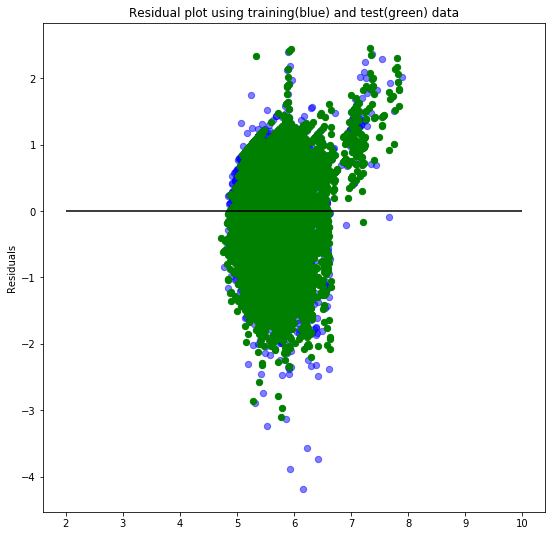

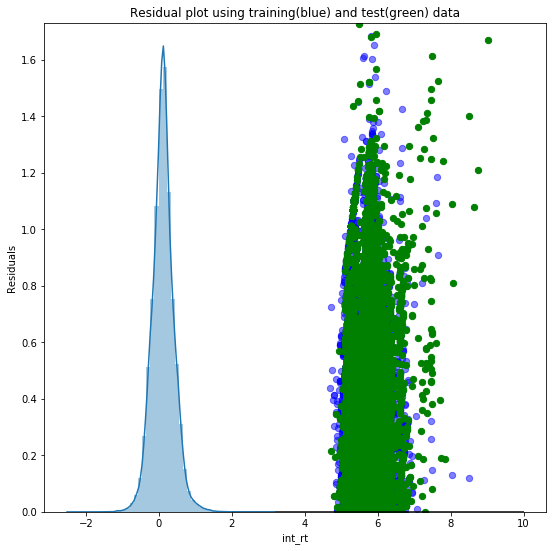

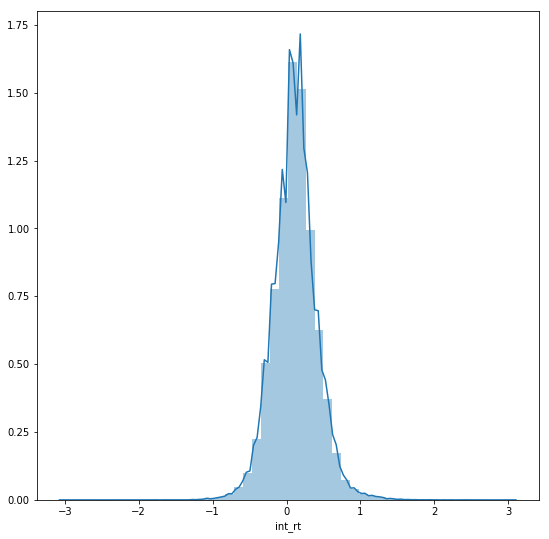

In [72]:
 train=quarter
test=testquarter

    # FeatureSelectionTechniques(train)
LinearRegressionAnalysis(train,test)

    

In [ ]:
RandomForestAnalysis(train,test)

In [73]:
Data1=trainModel(quarter)
TestData1=trainModel(testquarter)
Data1=checkAllReqColumns(Data1)
TestData1=checkAllReqColumns(TestData1)
y_train1=Data1.int_rt
Data1=Data1.drop('int_rt',axis=1)
x_train1=Data1
y_test1=TestData1.int_rt
TestData1.drop('int_rt',axis=1,inplace=True)
x_test1=TestData1

nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                    activation='relu', # activation function in the nodes of the neral net
                                    solver='adam', # optimizer algorithm
                                    learning_rate='constant',
                                    learning_rate_init=0.001, # initial learning rate
                                    max_iter=50, # max iterations to train for
                                    tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                    shuffle=True,
                                    verbose=True) # show details at each iteration
nn_model = nn_model.fit(x_train1, y_train1.values.ravel())

Iteration 1, loss = 4589098.84274377
Iteration 2, loss = 1.30230868
Iteration 3, loss = 1.22875676
Iteration 4, loss = 1.21609709
Iteration 5, loss = 1.69700294
Iteration 6, loss = 6.82985037
Iteration 7, loss = 68.07257071
Iteration 8, loss = 87.01125373
Iteration 9, loss = 86.71354281
Iteration 10, loss = 116.10835692
Iteration 11, loss = 65.47805921
Iteration 12, loss = 86.39555071
Iteration 13, loss = 130.54447772
Iteration 14, loss = 84.89670294
Iteration 15, loss = 95.87307963
Iteration 16, loss = 64.66642333
Training loss did not improve more than tol=-1.000000 for 10 consecutive epochs. Stopping.


In [74]:
nn_model_predictions = nn_model.predict(x_test1)

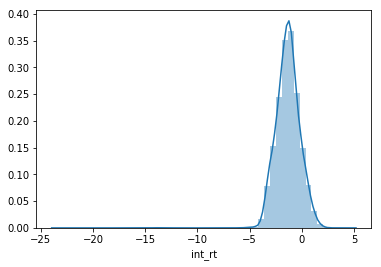

In [75]:
sns.distplot((y_test1-nn_model_predictions),bins=50)

In [76]:
calc_error_metric('Neural Network', nn_model, x_train1, y_train1, x_test1, y_test1)

,Model,mae_test,mae_train,mape_test,mape_train,r2_test,r2_train,rms_test,rms_train
0,Linear Regression,0.247804,0.213580,4.226464,3.779000,0.141400,0.378247,0.324859,0.289985
0,Random Forest Regressor,0.243345,0.204917,4.153833,3.628222,0.186015,0.434457,0.316306,0.276566
0,Neural Network,1.468431,1.494523,25.636405,26.572565,-24.394059,-22.894344,1.766709,1.797688


Here we can see that random forest is the best

In [77]:
import h2o

In [78]:
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\ritua\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ritua\AppData\Local\Temp\tmpp083aq7l
  JVM stdout: C:\Users\ritua\AppData\Local\Temp\tmpp083aq7l\h2o_ritua_started_from_python.out
  JVM stderr: C:\Users\ritua\AppData\Local\Temp\tmpp083aq7l\h2o_ritua_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_ritua_gf19d6
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [79]:
df_train = trainModel(quarter)
df_train.to_csv('Training_Data.csv')

In [80]:
Training_data_csv = "Training_Data.csv" 
data = h2o.import_file(Training_data_csv)  

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [81]:
data.shape

(351634, 33)

In [82]:
data.columns

['C1',
 'fico',
 'mi_pct',
 'cnt_units',
 'cltv',
 'dti',
 'orig_upb',
 'ltv',
 'int_rt',
 'orig_loan_term',
 'cnt_borr',
 'flag_fthb9',
 'flag_fthbN',
 'flag_fthbY',
 'occpy_stsI',
 'occpy_stsP',
 'occpy_stsS',
 'channelB',
 'channelC',
 'channelR',
 'channelT',
 'ppmt_pnltyN',
 'ppmt_pnltyX',
 'ppmt_pnltyY',
 'prop_type99',
 'prop_typeCO',
 'prop_typeCP',
 'prop_typeMH',
 'prop_typePU',
 'prop_typeSF',
 'loan_purposeC',
 'loan_purposeN',
 'loan_purposeP']

In [83]:
y_train = 'int_rt'
x_train = data.columns

In [84]:
 #remove the response
x_train.remove(y_train)  

In [85]:
x_train

['C1',
 'fico',
 'mi_pct',
 'cnt_units',
 'cltv',
 'dti',
 'orig_upb',
 'ltv',
 'orig_loan_term',
 'cnt_borr',
 'flag_fthb9',
 'flag_fthbN',
 'flag_fthbY',
 'occpy_stsI',
 'occpy_stsP',
 'occpy_stsS',
 'channelB',
 'channelC',
 'channelR',
 'channelT',
 'ppmt_pnltyN',
 'ppmt_pnltyX',
 'ppmt_pnltyY',
 'prop_type99',
 'prop_typeCO',
 'prop_typeCP',
 'prop_typeMH',
 'prop_typePU',
 'prop_typeSF',
 'loan_purposeC',
 'loan_purposeN',
 'loan_purposeP']

In [86]:
df_test = trainModel(testquarter)
df_test.to_csv('Testing_Data.csv')

In [87]:
Testing_data_csv = "Testing_Data.csv" 
data1 = h2o.import_file(Testing_data_csv) 

y_test='int_rt'
x_test = data1.columns

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [88]:
x_test.remove(y_test)

In [89]:
print(data.shape)
print(data1.shape)

(351634, 33)
(405679, 33)


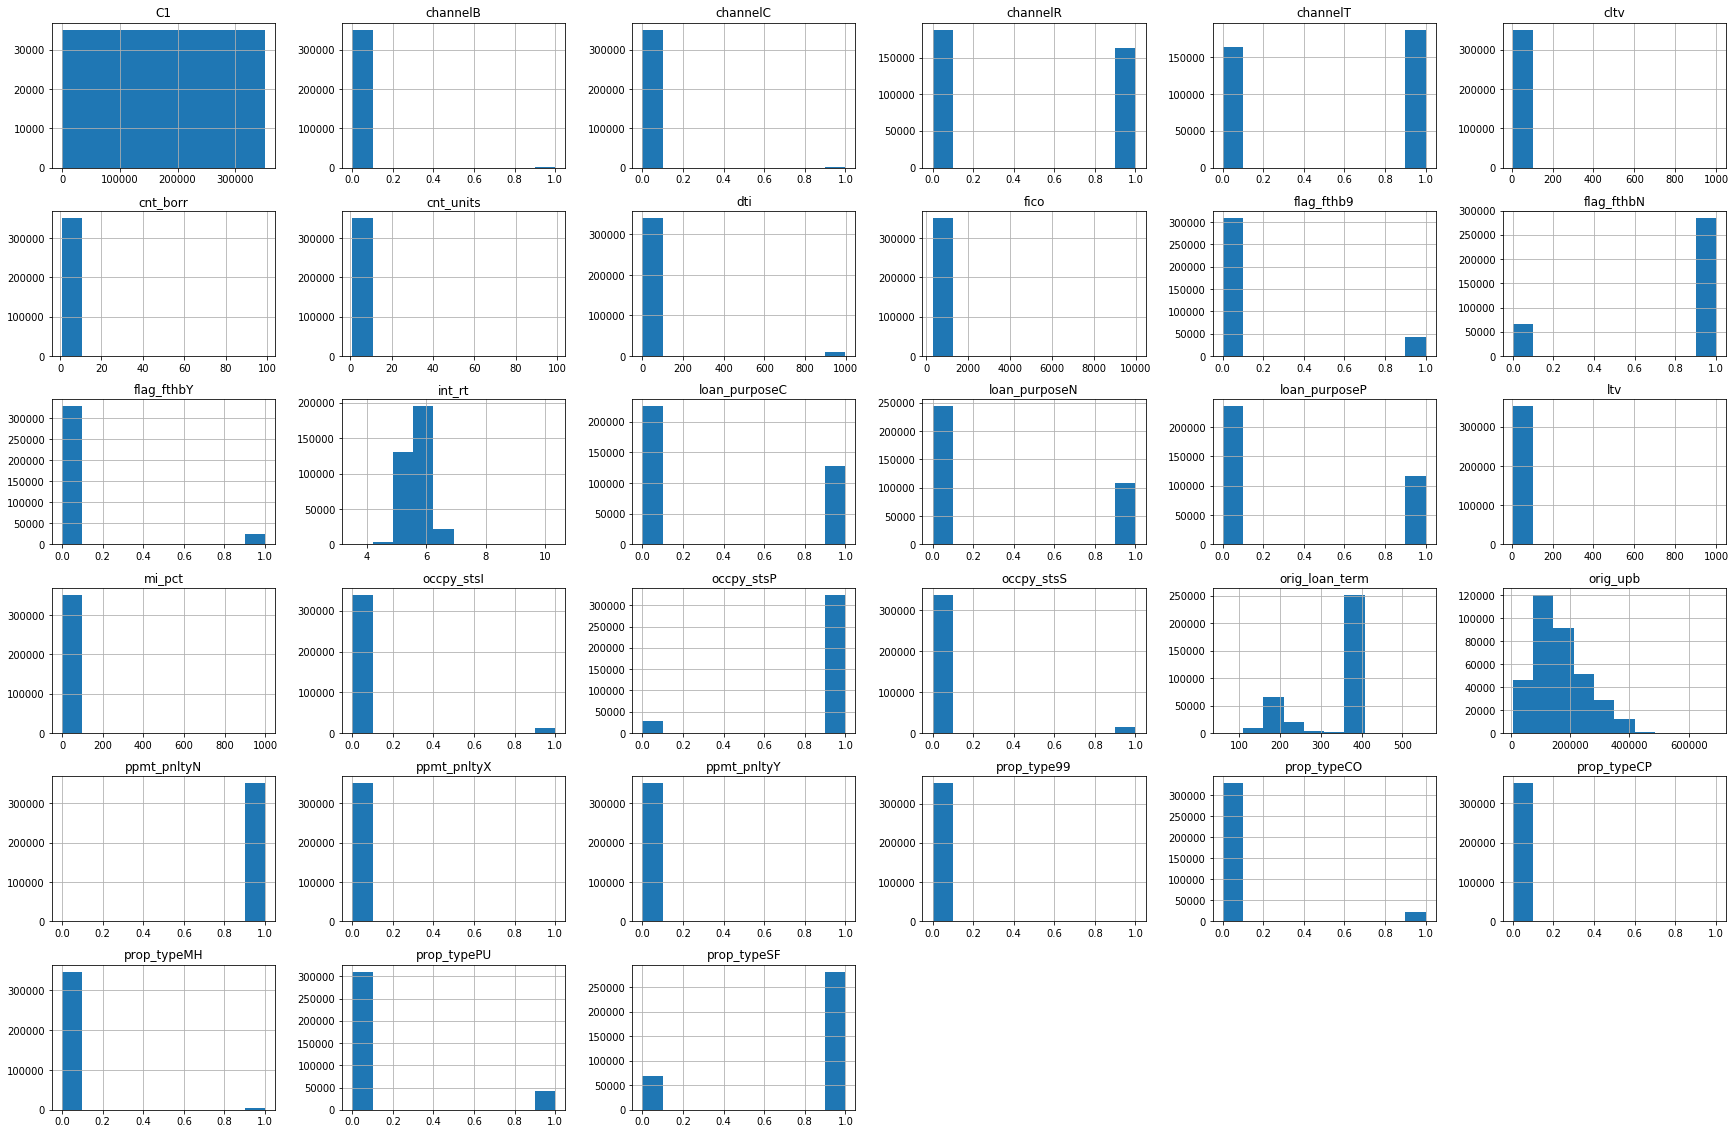

In [90]:
import pylab as pl
data.as_data_frame().hist(figsize=(30,20))
pl.show()

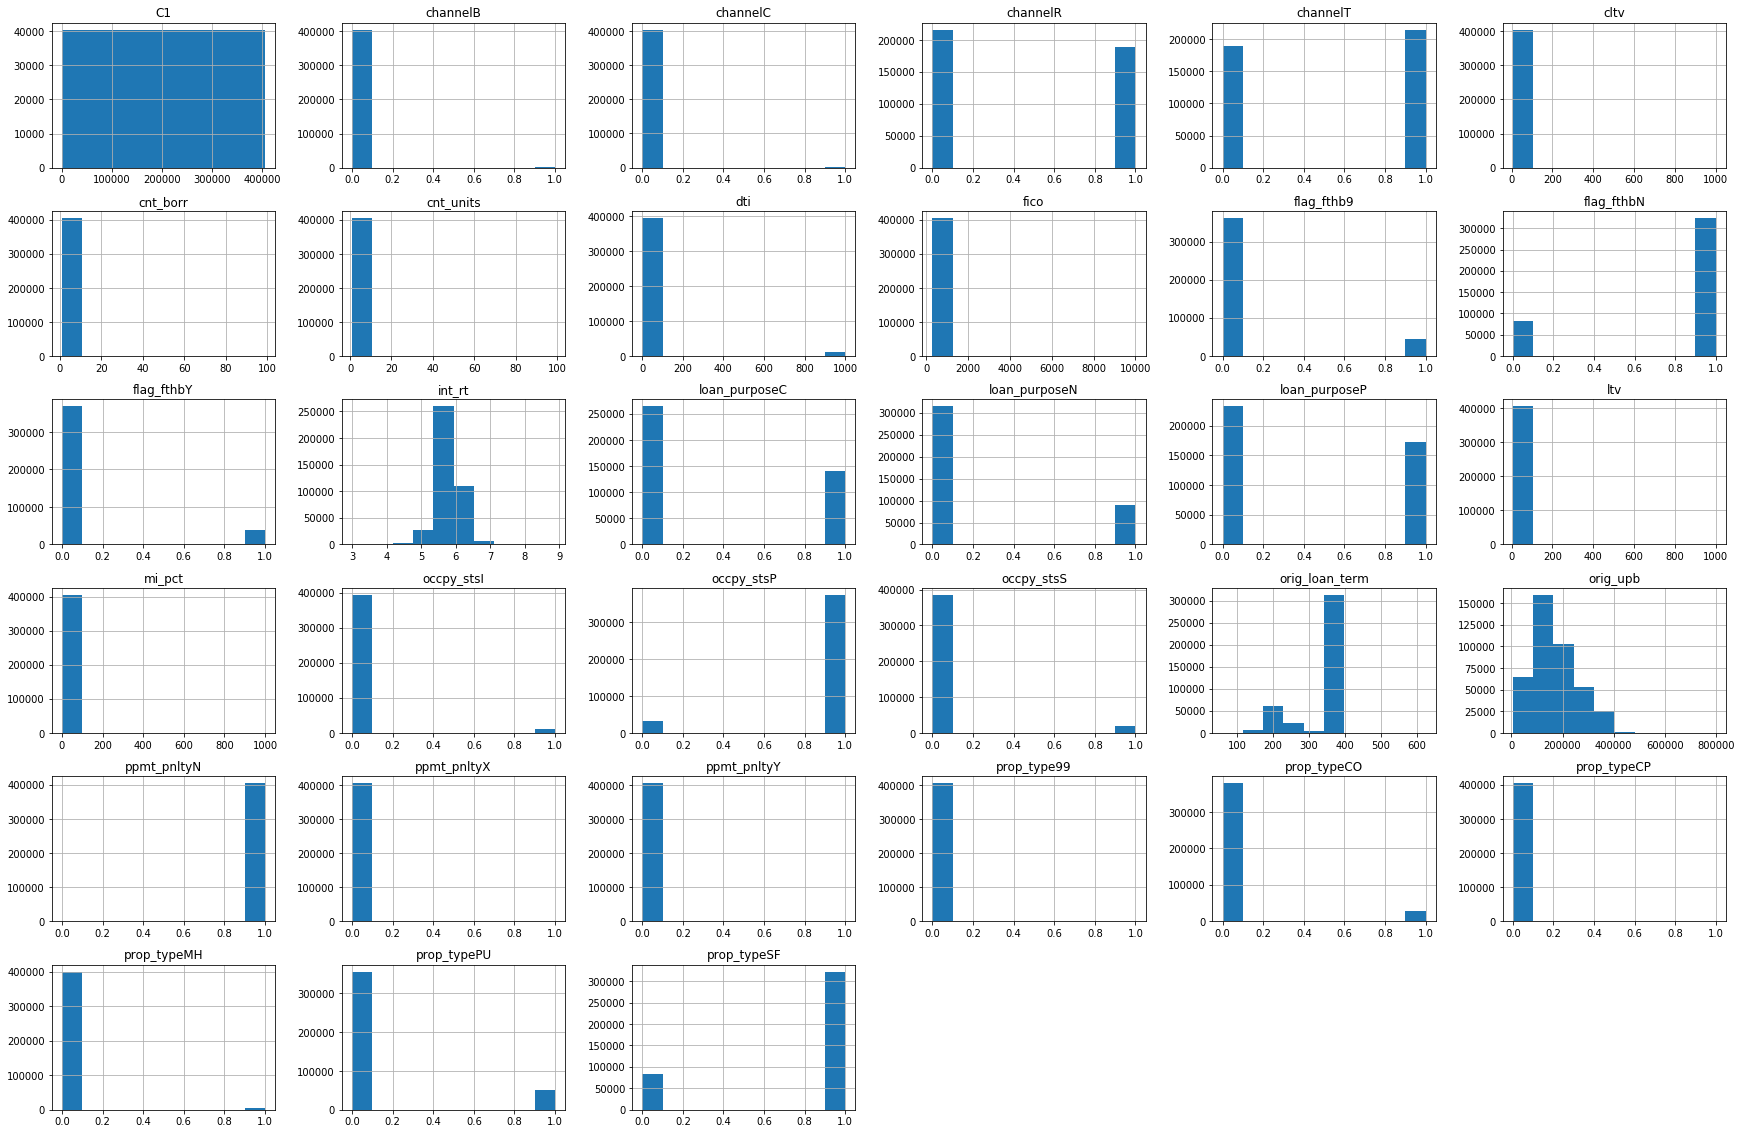

In [91]:
import pylab as pl
data1.as_data_frame().hist(figsize=(30,20))
pl.show()

In [92]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [93]:
h2o_glm = H2OGeneralizedLinearEstimator(nfolds = 5)

In [94]:
h2o_glm.train(x = x_train, y = y_train, training_frame= data)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [95]:
h2o_glm

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1543584235864_1


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.08387168932294989
RMSE: 0.28960609338021515
MAE: 0.21324998202673287
RMSLE: 0.043169994889018015
R^2: 0.37987150965378935
Mean Residual Deviance: 0.08387168932294989
Null degrees of freedom: 351633
Residual degrees of freedom: 351608
Null deviance: 47558.10781555675
Residual deviance: 29492.13760338616
AIC: 126434.7444267603

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.0839216245281585
RMSE: 0.28969229283527465
MAE: 0.2132762531676153
RMSLE: 0.04318063308935781
R^2: 0.37950229992787843
Mean Residual Deviance: 0.0839216245281585
Null degrees of freedom: 351633
Residual degrees of freedom: 351608
Null deviance: 47558.14885947673
Residual deviance: 29509.696519334488
AIC: 126644.03663350787
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,0.2132768,0.0005574,0.2138792,0.2129120,0.2128476,0.2122755,0.2144699
mean_residual_deviance,0.0839224,0.0006744,0.0845177,0.0837376,0.0830772,0.0828452,0.0854340
mse,0.0839224,0.0006744,0.0845177,0.0837376,0.0830772,0.0828452,0.0854340
null_deviance,9511.63,73.17848,9514.958,9591.536,9448.985,9354.674,9647.995
r2,0.3794965,0.0018320,0.3781188,0.3844651,0.3793662,0.3784637,0.3770686
residual_deviance,5901.9395,45.850933,5917.1704,5903.922,5864.3335,5814.245,6010.026
rmse,0.2896889,0.0011627,0.2907193,0.2893746,0.2882311,0.2878285,0.2922910
rmsle,0.0431804,0.0001383,0.0433203,0.0430942,0.0430315,0.0429657,0.0434902


Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2018-11-30 08:26:46,0.000 sec,0,47558.1079865,0.1352489


In [96]:
h2o_glm_pred= h2o_glm.predict(data1)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [97]:
h2o_glm_pred

predict
5.73973
5.67046
5.7319
5.70033
5.87046
5.83516
5.86681
5.83647
5.83686
5.88017


In [98]:
h2o_glm.model_performance(data)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 0.08387168932294989
RMSE: 0.28960609338021515
MAE: 0.21324998202673287
RMSLE: 0.043169994889018015
R^2: 0.37987150965378935
Mean Residual Deviance: 0.08387168932294989
Null degrees of freedom: 351633
Residual degrees of freedom: 351608
Null deviance: 47558.10781555675
Residual deviance: 29492.13760338616
AIC: 126434.7444267603


In [99]:
h2o_glm.model_performance(data1)


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 0.10553363242248862
RMSE: 0.32485940408504205
MAE: 0.24844514084578082
RMSLE: 0.047560124763358747
R^2: 0.1413962969208189
Mean Residual Deviance: 0.10553363242248862
Null degrees of freedom: 405678
Residual degrees of freedom: 405653
Null deviance: 56735.384459798675
Residual deviance: 42812.77846752276
AIC: 239060.38336642054


Variable importance does not apply to GLM. Will use std_coef_plot() instead.


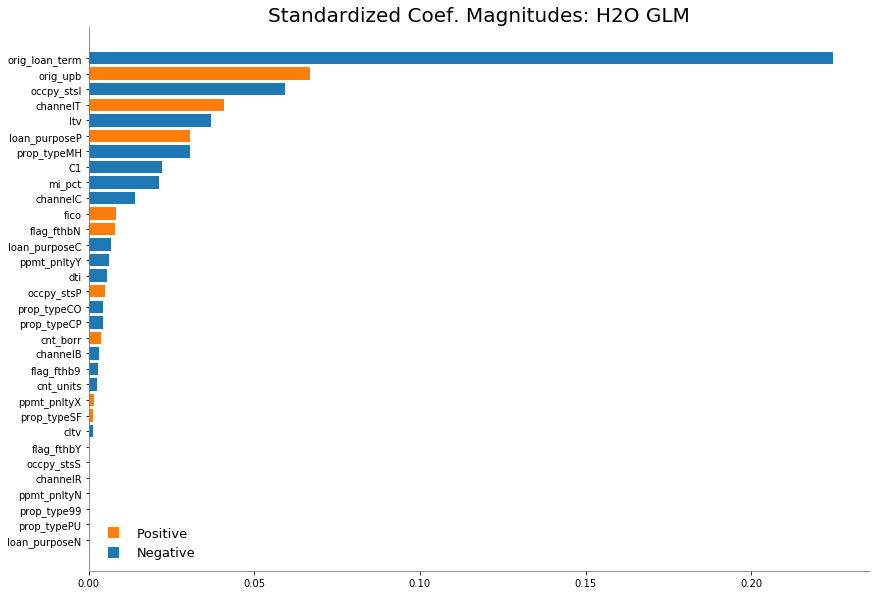

In [100]:
h2o_glm.varimp_plot()

In [101]:
# Random Forest Estimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [102]:
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1)

In [103]:
rf_fit1.train(x=x_train, y=y_train, training_frame=data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [104]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x_train, y=y_train, training_frame=data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [105]:
rf_perf1 = rf_fit1.model_performance(data1)
rf_perf2 = rf_fit2.model_performance(data1)

In [106]:
rf_perf1


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.1006339160496734
RMSE: 0.3172284918629999
MAE: 0.24509472426239198
RMSLE: 0.04659877455244077
Mean Residual Deviance: 0.1006339160496734


In [107]:
rf_perf2


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.09974062777428995
RMSE: 0.315817396250254
MAE: 0.24399638452778136
RMSLE: 0.04637665591852622
Mean Residual Deviance: 0.09974062777428995


In [108]:
rf_fit3 = H2ORandomForestEstimator(model_id='rf_fit3', seed=1, nfolds=5)
rf_fit3.train(x=x_train, y=y_train, training_frame=data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [109]:
rf_perf3=rf_fit3.model_performance(data1)

In [110]:
rf_perf3


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.1006339160496734
RMSE: 0.3172284918629999
MAE: 0.24509472426239198
RMSLE: 0.04659877455244077
Mean Residual Deviance: 0.1006339160496734


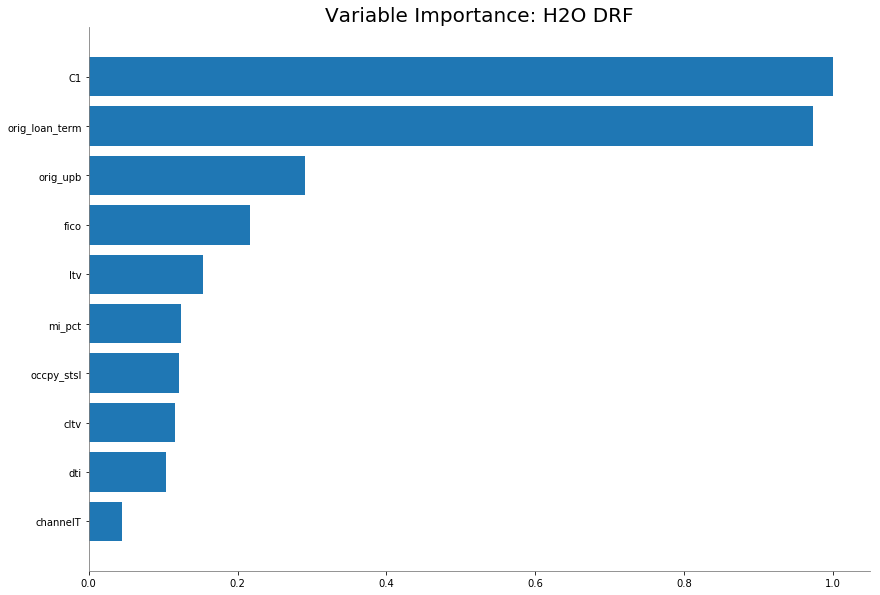

In [111]:
rf_fit2.varimp_plot()

# DeepLearningEstimator

In [112]:
# Import H2O DL:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [113]:
# Initialize and train the DL estimator:

dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=x_train, y=y_train, training_frame=data)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [114]:
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=x_train, y=y_train, training_frame=data)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [115]:
dl_perf1 = dl_fit1.model_performance(data1)
dl_perf2 = dl_fit2.model_performance(data1)

In [116]:
dl_perf1


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.10042571633043772
RMSE: 0.3169001677665029
MAE: 0.24418694685219353
RMSLE: 0.046446607004345296
Mean Residual Deviance: 0.10042571633043772


In [117]:
dl_perf2


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.09657662270072213
RMSE: 0.3107677954690964
MAE: 0.23776265443553282
RMSLE: 0.045546887459598694
Mean Residual Deviance: 0.09657662270072213


# tpot

In [23]:
from tpot import TPOTRegressor
pipeline_optimizer = TPOTRegressor()

C:\Users\ritua\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\ritua\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\ritua\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [ ]:
pipeline_optimizer = TPOTRegressor(generations=2, population_size=3, cv = 3,
                                    random_state=42, verbosity=2)

In [ ]:
Data1=trainModel(quarter)
TestData1=trainModel(testquarter)
Data1=checkAllReqColumns(Data1)
TestData1=checkAllReqColumns(TestData1)
y_train1=Data1.int_rt
Data1=Data1.drop('int_rt',axis=1)
x_train1=Data1
y_test1=TestData1.int_rt
TestData1.drop('int_rt',axis=1,inplace=True)
x_test1=TestData1

pipeline_optimizer.fit(x_train1,y_train1)

In [ ]:
print('The RMSE of TPOT Regressor is {}'.format(pipeline_optimizer.score(x_test,y_test)))

# What -if Analysis on 3 different scenarios

In [118]:
Financial_Crisis()

Financial Crisis Analysis for Quarter Q12007 as a training data
Training Data:
MAE:0.22029121132003052
RMSE:0.29053590405050755
Median Absolute Error:0.1757616575346761
Financial Crisis Analysis for Quarter Q22007 as a training data
Training Data:
MAE:0.24305294115468107
RMSE:0.31807508923618355
Median Absolute Error:0.1937905247075693
Financial Crisis Analysis for Quarter Q32007 as a training data
Training Data:
MAE:0.23477958736264884
RMSE:0.30845463867163997
Median Absolute Error:0.18803151646280636
loading saved cookies
{'username': 'agrawal.ritu@husky.neu.edu', 'password': 'jRodIxOV'}
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q22005&s=330868332
--------------------------------------------------------------------------------------
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q42007&s=169032178


Financial Crisis Analysis for Quarter Q42007 as a training data
Training Data:
MAE:0.2614643340836274
RMSE:0.3419200817811143
Median Absolute Error:0.20894987667121967
Financial Crisis Analysis for Quarter Q22007 as a testing data
Testing Data
MAE:0.2608170023397367
RMSE:0.3383587574319501
Median Absolute Error:0.2122477268963241
Financial Crisis Analysis for Quarter Q32007 as a testing data
Testing Data
MAE:0.3644406094480487
RMSE:0.44275581621031107
Median Absolute Error:0.333681438669557
Financial Crisis Analysis for Quarter Q42007 as a testing data
Testing Data
MAE:0.2614643340836274
RMSE:0.3419200817811143
Median Absolute Error:0.20894987667121967
loading saved cookies
{'username': 'agrawal.ritu@husky.neu.edu', 'password': 'jRodIxOV'}
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q22005&s=330868332
--------------------------------------------------------------------------------------
C:\Users\ritua/HistoricalInputFiles
h

Financial Crisis Analysis for Quarter Q12008 as a testing data
Testing Data
MAE:0.4805825508335983
RMSE:0.5644570686514722
Median Absolute Error:0.4589934069036268


In [168]:
economic_boom(quarter)

Training Data for quarter that user has input:
MAE:0.19634733528903936
RMSE:0.2641659071030601
Median Absolute Error:0.1503490627878583
Performance on Economic Boom year's Data
MAE:1.0947891001680081
RMSE:1.1407715767636384
Median Absolute Error:1.068093804012547
Performance on Economic Boom year's Data


ValueError: Number of features of the model must match the input. Model n_features is 36 and input n_features is 35 

In [167]:
regime_change_election()

loading saved cookies
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q22005&s=330868332
--------------------------------------------------------------------------------------
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q42015&s=88547109




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]







Training Data Results:
MAE:0.17121788655898518
RMSE:0.22021194184315945
Median Absolute Error:0.13979328070435226
loading saved cookies
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q22005&s=330868332
--------------------------------------------------------------------------------------
C:\Users\ritua/HistoricalInputFiles
https://freddiemac.embs.com/FLoan/Data/download.php?f=historical_data1_Q12016&s=74856005




  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 